## Модели AR, MA и ARIMA
свободный перевод [Algorithm Breakdown: AR, MA and ARIMA models](https://www.ritchievink.com/blog/2018/09/26/algorithm-breakdown-ar-ma-and-arima-models/)

Временные ряды являются довольно уникальной темой в машинном обучении. В большинстве задач зависимая переменная $y$, то есть та штука которую мы хотим предсказать, зависит от чистоты входных данных, таких как пиксели изображения, слова в предложении, свойства покупательского поведения и т. д. Во временных рядах независимые переменные часто неизвестны. Например, для фондовых рынков у нас нет независимого набора переменных, на основе которых мы можем построить модель. Зависят ли фондовые рынки от свойств компании или от свойств страны, или они зависят от настроений в новостях? Конечно, мы можем попытаться найти отношения между этими независимыми переменными и результатами фондового рынка и, возможно, мы сможем найти несколько хороших моделей, отображающих эти отношения. Дело в том, что эти отношения не очень ясны, а независимые переменные получить нелегко. 

Общий подход при моделировании временных рядов состоит в том, чтобы рассматривать метку на текущем временном шаге $X_t$ как переменную, зависящую от предыдущих временных шагов $X_{t-k}$.
Таким образом для анализа временного ряда нам будет достаточно данных о самом ряде.

Одной из часто используемых моделей при обработке времеренных рядов являются модели ARIMA. В этом посте мы рассмотрим как определяются эти модели, и разработаем такую модель на python, используя только пакет numpy.

### Стохастический ряд

Модели ARIMA на самом деле представляют собой комбинацию двух процессов, способных генерировать ряд данных. Эти две модели основаны на процессе авторегрессии AR и процессе скользящего среднего MA. Оба процесса AR и MA являются стохастическими процессами. Стохастический означает, что значения исходят из случайного распределения вероятностей, которое может быть проанализировано статистически, но не может быть точно предсказано. Другими словами, оба процесса имеют некоторую неопределенность. 

### Белый шум

Давайте посмотрим на очень простой стохастический процесс, который называется *белый шум*. Белый шум можно получить из многих видов распределений. Здесь мы опираемся на стандартное Гауссовское $\epsilon$ ~ $N(0,1)$

In [1]:
import warnings
warnings.filterwarnings("ignore")

<AxesSubplot:ylabel='Density'>

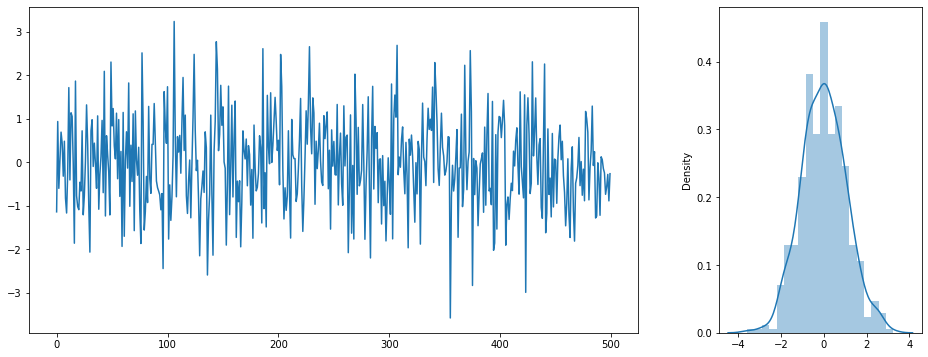

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy

n = 500
fig, ax = plt.subplots(1,2, figsize=(16, 6), gridspec_kw={'width_ratios':[3, 1]})
eps = np.random.normal(size=n)
ax[0].plot(eps)
sns.distplot(eps, ax=ax[1])

Этот процесс полностью случайный, хотя мы можем вывести некоторые свойства из этого ряда. Построив график распределения, мы можем предположить, что эти переменные происходят из одного нормального распределения с нулевым средним и единичной дисперсией. Нашим лучшим предположением для любого нового значения переменной будет значение $0$. Лучшей модели для этого процесса не существует, поскольку каждое новое взятие из распределения является полностью случайным и независимым от предыдущих значений. На самом деле белый шум — это то, что мы хотим видеть на [остатках](https://en.wikipedia.org/wiki/Errors_and_residuals) после того, как мы определили модель. Если остатки следуют шаблону белого шума, мы можем быть уверены, что объявили всю возможную дисперсию. (?)

Стоит также отметить что белый шум является стационарным рядом

### Mean average process

Процесс скользящего среднего фактически основан на белом шуме. Он определяется как средневзвешенное значение предыдущих значений белого шума

$$\Large X_t = \mu + \epsilon_t + \sum_{i=1}^{q} \theta_i \epsilon_{t-i}$$

где $\theta$ — параметры процесса, а $q$ — порядок процесса. Под порядком подразумевается сколько предыдущих значений включается в средневзвешенное значение, иными словами это размер окна

In [3]:
def lag_view(eps, order):
    return np.array([
        eps[i: i + order]
        for i in range(len(eps) - order)
    ])

In [4]:
def ma_process(eps, order):
    theta = np.hstack((np.array([1]), np.random.uniform(0, 1, size=order)))
    eps_lag = lag_view(eps, len(theta))
    return eps.mean() + eps_lag @ theta[::-1]

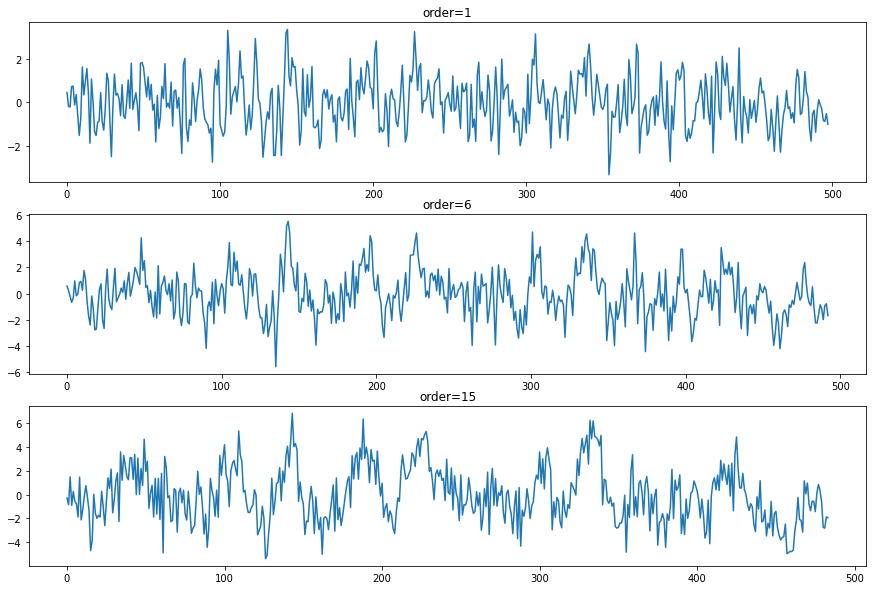

In [5]:
fig, ax = plt.subplots(3, 1, figsize=(15,10))

ax[0].plot(ma_process(eps, 1))
ax[0].set_title("order=1")

ax[1].plot(ma_process(eps, 6))
ax[1].set_title("order=6")

ax[2].plot(ma_process(eps, 15))
ax[2].set_title("order=15")

plt.show()

На графиках выше видно, что при увеличении порядка $q$ значения больше коррелируют с предыдущими значениями. Действительно, поскольку процесс представляет собой средневзвешенное значение случайной величины $\epsilon$ с размером окна $q$, корреляция уменьшается вне окна. Основываясь на этом свойстве, мы можем сделать обоснованное предположение о порядке процесса. Это здорово, потому что очень сложно вывести порядок, глядя на графики напрямую. 

### Автокорреляция

Когда значение $X_t$ коррелирует с $X_{t-k}$ это называется автокорреляцией. Функция автокорреляции определяется как [корреляция Пирсона](https://translated.turbopages.org/proxy_u/en-ru.ru.428253d8-621a2c1c-cf0cdcfd-74722d776562/https/en.wikipedia.org/wiki/Pearson_correlation_coefficient)

$$\Large ACF(X_t, X_{t-k}) = \frac{cov(X_t, X_{t-k})}{\sigma_t \sigma_{t-k}} = \frac{E[(X_t - \mu_t)(X_{t-k} - \mu_{t-k})]}{\sigma_t \sigma_{t-k}}$$

In [6]:
def pearson_correlation(x, y):
    return np.mean((x - x.mean()) * (y - y.mean())) / (x.std() * y.std())

def acf(x, lag=40):
    return np.array([1] + [pearson_correlation(x[:-i], x[i:]) for i in range(1, lag)])

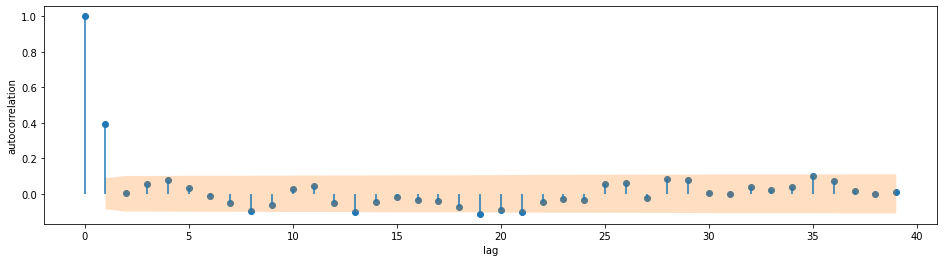

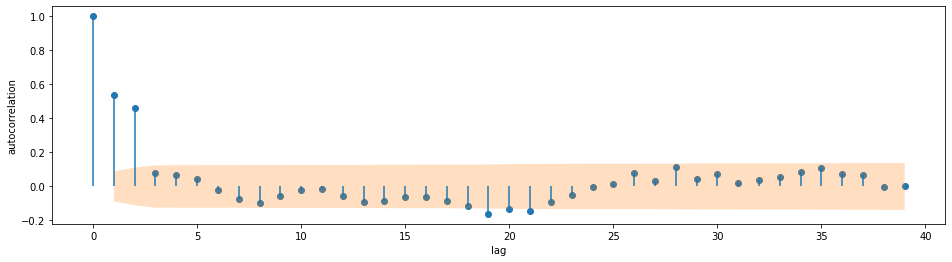

In [7]:
import scipy.stats as stats

def bartletts_formula(acf_array, n):
    se = np.zeros(len(acf_array) - 1)
    se[0] = 1 / np.sqrt(n)
    se[1:] = np.sqrt((1 + 2 * np.cumsum(acf_array[1:-1]**2)) / n)
    return se

def plot_acf(x, alpha=0.05, lag=40):
    acf_val = acf(x, lag)
    plt.figure(figsize=(16, 4))
    plt.vlines(np.arange(lag), 0, acf_val)
    plt.scatter(np.arange(lag), acf_val, marker='o')
    plt.xlabel('lag')
    plt.ylabel('autocorrelation')
    
    ci = stats.norm.ppf(1 - alpha / 2.) * bartletts_formula(acf_val, len(x))
    plt.fill_between(np.arange(1, ci.shape[0] + 1), -ci, ci, alpha=0.25)
    
for array in [ma_process(eps, 1), ma_process(eps, 2)]:
    plot_acf(array)

Эти графики помогают нам определить порядок процесса $q$. На обоих графиках видно четкое отсечение значимых значений. Оба графика начинаются с автокорреляции равной 1, это автокорреляция с лагом 0. Второе значение — это автокорреляция с лагом 1, третья — с лагом 2 и т. д. На первом графике отсечка происходит после 1 лага, а на втором на после 2 лага, таким образом номер лага и есть порядок

[Что такое коррелограмма](https://en.wikipedia.org/wiki/Correlogram)

### Autoregressive process

Выше мы смоделировали $MA$ процесс и определили что такое автокорреляция, чтобы научиться находить порядок процесса. Теперь смоделируем другой ряд, который называется $AR$ процесс, и также попробуем определить его порядок. Процесс $AR$ определяется как $$\Large X_t = c + \epsilon_t + \sum_{i=1}^{p} \phi_i X_{t-i}$$

Теперь $\phi$ это параметры процесса, а $p$ его порядок. $MA(q)$ является средневзвешенным значением ошибок (белый шум), $AR(p)$ является средневзвешенным значением предыдущих значений ряда $X_{t-p}$. Процесс $AR$ также имеет переменную белого шума, что делает его стохастическим рядом. В $MA$ мы заранее формируем все лаги, и заменяем каждый на средневзвешенное значение. В $AR$ рсчеты проходят на ходу, т.е. новые значения процесса получаются на основании предыдущих уже посчитанных.

In [8]:
def ar_process(eps, order):
    phi = np.hstack((np.array([1]), np.random.normal(0, 0.1, size=order)))
    offset = len(phi)
    for i in range(offset, len(eps)):
        eps[i - 1] = eps[i - offset: i] @ phi[::-1]
    return eps.mean() + eps

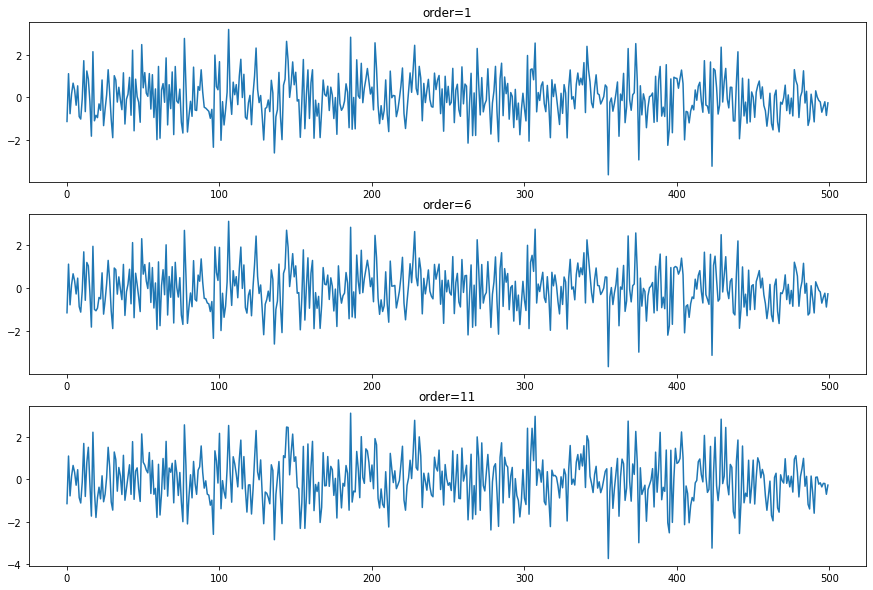

In [9]:
fig, ax = plt.subplots(3, 1, figsize=(15,10))

ax[0].plot(ar_process(eps, 1))
ax[0].set_title("order=1")

ax[1].plot(ar_process(eps, 6))
ax[1].set_title("order=6")

ax[2].plot(ar_process(eps, 11))
ax[2].set_title("order=11")

plt.show()

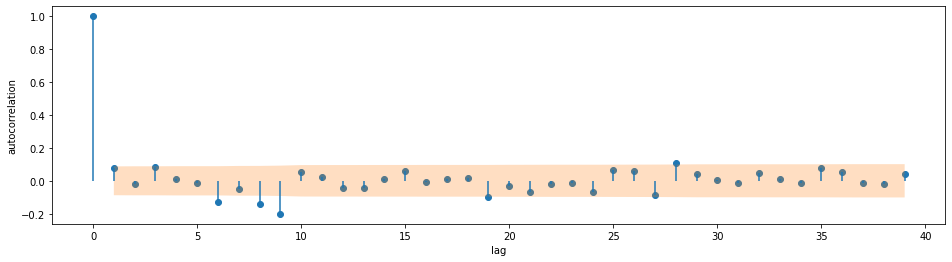

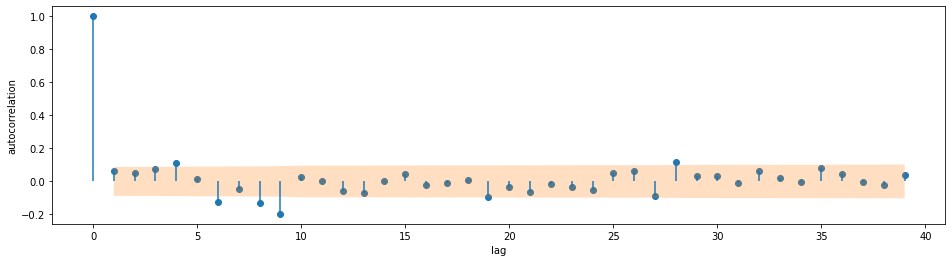

In [10]:
for array in [ar_process(eps, 4), ar_process(eps, 6)]:
    plot_acf(array)

Анализируя эти графики, можно сказать, что график $ACF$ для процессов $AR$ явно не имеет решающего значения для определения порядка процесса. Для процессов $AR$ мы можем использовать другую функцию для определения порядка процесса.

### Partial autocorrelation

свободный перевод [Partial correlation-the idea and significance](https://towardsdatascience.com/partial-correlation-508353cd8b5)

Вспомним, что корреляция описывает такую связь между двумя переменными, при которой рост (уменьшение) одной из них вызывает рост (уменьшение) другой. Существует несколько способов измерить корреляцию между двумя переменными. Например, через коэффициент Пирсона, который определяется как $$\rho(X, Y) = \frac{cov(X, Y)}{\sigma_X \sigma_Y}$$

корреляция нормализует ковариацию путем деления ее на стандартное отклонение двух переменных. В отличие от ковариации, диапазон корреляции находится между -1 и 1. Когда он равен -1 или 1, это означает, что отношение между двумя переменными задано в точности как линейная функция с положительным или отрицательным наклоном соответственно.

Мы можем вычислить корреляцию для наблюдений временного ряда с наблюдениями с предыдущими временными шагами, называемыми лагами. Поскольку корреляция наблюдений временного ряда рассчитывается со значениями того же ряда в предыдущие моменты времени, это называется последовательной корреляцией или автокорреляцией.

![img](./img/arima_pacf.jpg)

То есть оценивается корреляция между $X_t$ и $X_{t-k}$ без вклада промежуточных элементов, которые оказывают ощутимое влияние в $AR$ процессе по его определению, и могут вводить в заблуждение если вычислять прямую корреляцию

In [11]:
from sklearn.linear_model import LinearRegression

In [12]:
reg = LinearRegression()

def pacf(x, lag=40):
    
    correlations = []
    # Partial auto correlation needs intermediate terms.
    # Therefore we start at index 3
    for i in range(3, lag+2):
        intermediate_lags = lag_view(x, i)
        
        features = intermediate_lags[:, 1:-1]
        xt = intermediate_lags[:, -1]
        xt_k = intermediate_lags[:, 0]
        
        model = reg.fit(features, xt)
        xt_pred = features @ model.coef_
        
        model = reg.fit(features, xt_k)
        xt_k_pred = features @ model.coef_
        
        r = pearson_correlation(xt - xt_pred, xt_k - xt_k_pred)
        correlations.append(r)
        
    return np.hstack((acf(x, 2), correlations))

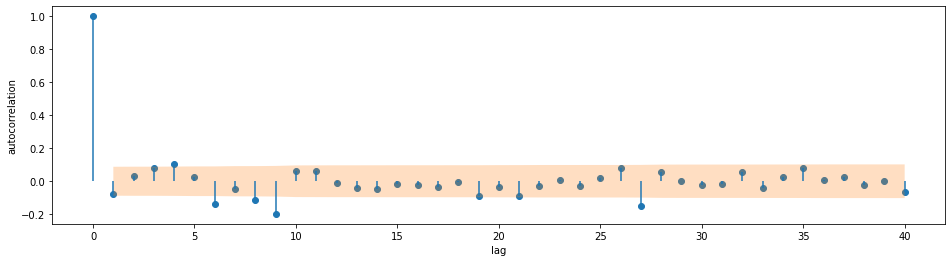

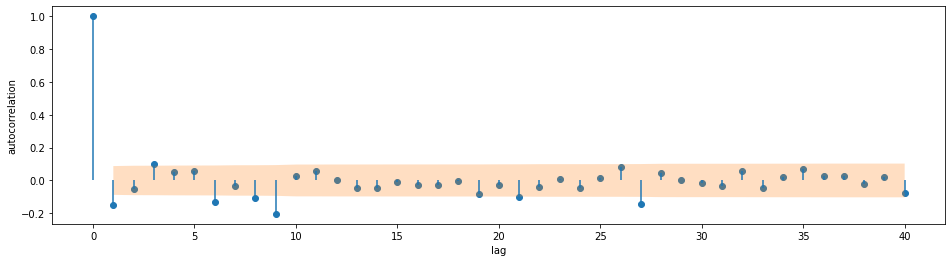

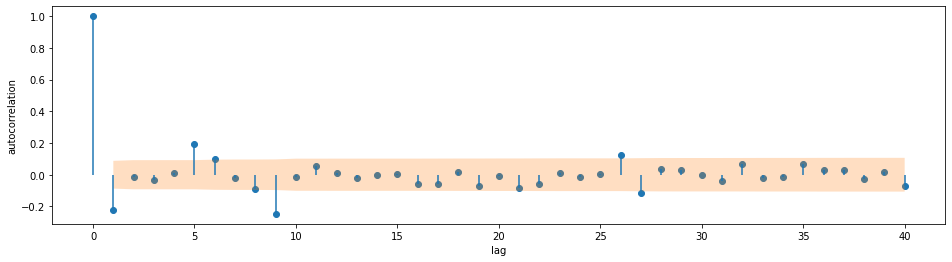

In [13]:
def plot_pacf(x, alpha=0.05, lag=40, title=None):
    pacf_val = pacf(x, lag)
    plt.figure(figsize=(16, 4))
    plt.vlines(np.arange(lag + 1), 0, pacf_val)
    plt.scatter(np.arange(lag + 1), pacf_val, marker='o')
    plt.xlabel('lag')
    plt.ylabel('autocorrelation')

    ci = stats.norm.ppf(1 - alpha / 2.) * bartletts_formula(pacf_val, len(x))
    plt.fill_between(np.arange(1, ci.shape[0] + 1), -ci, ci, alpha=0.25)

for array in [ar_process(eps, 3), ar_process(eps, 4), ar_process(eps, 6)]:
    plot_pacf(array)

### Стационарность ряда

Модель $ARMA$ требует чтобы ряд был стационарным, в то время как $ARIMA$ нет. Стационарный ряд имеет постоянное среднее и постоянное стандартное отклонение на протяжении всего времени. Для белого шума, процессов $AR$ и $MA$, которые мы определили выше, это требование выполняется, но для большого количества реальных данных это не так. Модели $ARIMA$ могут работать с данными, которые не стационарны, а имеют тренд, т.е. потенциал меняться в большую или меньшую сторону.

Когда данные имеют тренд, мы можем удалить его, дифференцировав значения $X_t$ и $X_{t-1}$. Будем дифференцировать $n$ раз до тех пор, пока данные не станут стационарными $$\Delta X_t = X_t - X_{t-1}$$ 

In [14]:
def difference(x, d=1):
    if d == 0:
        return x
    else:
        x = np.r_[x[0], np.diff(x)]
        return difference(x, d - 1)
    
def undo_difference(x, d=1):
    if d == 1:
        return np.cumsum(x)
    else:
        x = np.cumsum(x)
        return undo_difference(x, d - 1)

### ARIMA

Модели $ARIMA$ имеют гиперпараметры $q$ - порядок $MA$ процесса, $p$ - порядок $AR$ процесса и $d$ - порядок дифференцирования, т.е. как часто мы будем производить эту операцию. Таким образом, модели $ARMA$ и $ARIMA$ определяются как $$\Large X_t = c + \epsilon_t + \sum_{i=1}^{q}\theta_i \epsilon_{t-i} + \sum_{i=1}^{p}\phi_i X_{t-i}$$

In [15]:
def least_squares(x, y):
    return np.linalg.inv((x.T @ x)) @ (x.T @ y)

class LinearModel:
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept
        self.beta = None
        self.intercept_ = None
        self.coef_ = None
    
    def _prepare_features(self, x):
        if self.fit_intercept:
            x = np.hstack((np.ones((x.shape[0], 1)), x))
        return x
    
    def fit(self, x, y):
        x = self._prepare_features(x)
        self.beta = least_squares(x, y)
        if self.fit_intercept:
            self.intercept_ = self.beta[0]
            self.coef_ = self.beta[1:]
        else:
            self.coef_ = self.beta
        
    def predict(self, x):
        x = self._prepare_features(x)
        return x @ self.beta
    
    def fit_predict(self, x, y):
        self.fit(x, y)
        return self.predict(x)
    
def lag_view(x, order):
    y = x.copy()
    x = np.array([y[-(i + order):][:order] for i in range(y.shape[0])])
    x = np.stack(x)[::-1][order - 1: -1]
    y = y[order:]

    return x, y

def pacf(x, lag=40):
    """
    Partial autocorrelation function.
    
    pacf results in:
        [1, acf_lag_1, pacf_lag_2, pacf_lag_3]
    :param x: (array)
    :param lag: (int)
    """
    y = []
    
    # Partial auto correlation needs intermediate terms.
    # Therefore we start at index 3
    for i in range(3, lag + 2):
        backshifted = lag_view(x, i)[0]

        xt = backshifted[:, 0]
        feat = backshifted[:, 1:-1]
        xt_hat = LinearModel(fit_intercept=False).fit_predict(feat, xt)

        xt_k = backshifted[:, -1]
        xt_k_hat = LinearModel(fit_intercept=False).fit_predict(feat, xt_k)

        y.append(pearson_correlation(xt - xt_hat, xt_k - xt_k_hat))
    return np.array([1, acf(x, 2)[1]] +  y)


class ARIMA(LinearModel):
    def __init__(self, q, d, p):
        """
        An ARIMA model.
        :param q: (int) Order of the MA model.
        :param p: (int) Order of the AR model.
        :param d: (int) Number of times the data needs to be differenced.
        """
        super().__init__(True)
        self.p = p
        self.d = d
        self.q = q
        self.ar = None
        self.resid = None
        
    def prepare_features(self, x):
        if self.d > 0:
            x = difference(x, self.d)
                    
        ar_features = None
        ma_features = None
        
        # Determine the features and the epsilon terms for the MA process
        if self.q > 0:
            if self.ar is None:
                self.ar = ARIMA(0, 0, self.p)
                self.ar.fit_predict(x)
            eps = self.ar.resid
            eps[0] = 0
            
            # prepend with zeros as there are no residuals_t-k in the first X_t
            ma_features, _ = lag_view(np.r_[np.zeros(self.q), eps], self.q)
            
        # Determine the features for the AR process
        if self.p > 0:
            # prepend with zeros as there are no X_t-k in the first X_t
            ar_features = lag_view(np.r_[np.zeros(self.p), x], self.p)[0]
                                
        if ar_features is not None and ma_features is not None:
            n = min(len(ar_features), len(ma_features)) 
            ar_features = ar_features[:n]
            ma_features = ma_features[:n]
            features = np.hstack((ar_features, ma_features))
        elif ma_features is not None: 
            n = len(ma_features)
            features = ma_features[:n]
        else:
            n = len(ar_features)
            features = ar_features[:n]
        
        return features, x[:n]
    
    def fit(self, x):
        features, x = self.prepare_features(x)
        super().fit(features, x)
        return features
            
    def fit_predict(self, x): 
        """
        Fit and transform input
        :param x: (array) with time series.
        """
        features = self.fit(x)
        return self.predict(x, prepared=(features))
    
    def predict(self, x, **kwargs):
        """
        :param x: (array)
        :kwargs:
            prepared: (tpl) containing the features, eps and x
        """
        features = kwargs.get('prepared', None)
        if features is None:
            features, x = self.prepare_features(x)
        
        y = super().predict(features)
        self.resid = x - y

        return self.return_output(y)
    
    def return_output(self, x):
        if self.d > 0:
            x = undo_difference(x, self.d) 
        return x
    
    def forecast(self, x, n):
        """
        Forecast the time series.
        
        :param x: (array) Current time steps.
        :param n: (int) Number of time steps in the future.
        """
        features, x = self.prepare_features(x)
        y = super().predict(features)
        
        # Append n time steps as zeros. Because the epsilon terms are unknown
        y = np.r_[y, np.zeros(n)]
        for i in range(n):
            feat = np.r_[y[-(self.p + n) + i: -n + i], np.zeros(self.q)]
            y[x.shape[0] + i] = super().predict(feat[None, :])
        return self.return_output(y)

## Предсказание с помощью ARIMA

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv("data/valve1/0.csv", sep=";", parse_dates=True, index_col="datetime")
y = df["changepoint"]
df.drop(["changepoint", "anomaly"], inplace=True, axis=1)
df.head()

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
datetime,,,,,,,,
2020-03-09 10:14:33,0.026588,0.040111,1.33020,0.054711,79.3366,26.0199,233.062,32.0
2020-03-09 10:14:34,0.026170,0.040453,1.35399,0.382638,79.5158,26.0258,236.040,32.0
2020-03-09 10:14:35,0.026199,0.039419,1.54006,0.710565,79.3756,26.0265,251.380,32.0
2020-03-09 10:14:36,0.026027,0.039641,1.33458,0.382638,79.6097,26.0393,234.392,32.0
2020-03-09 10:14:37,0.026290,0.040273,1.07851,-0.273216,79.6109,26.0420,225.342,32.0


Будем предсказывать температуру

<AxesSubplot:xlabel='datetime'>

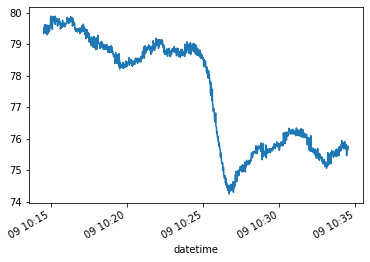

In [17]:
x = df["Temperature"].values
df["Temperature"].plot()

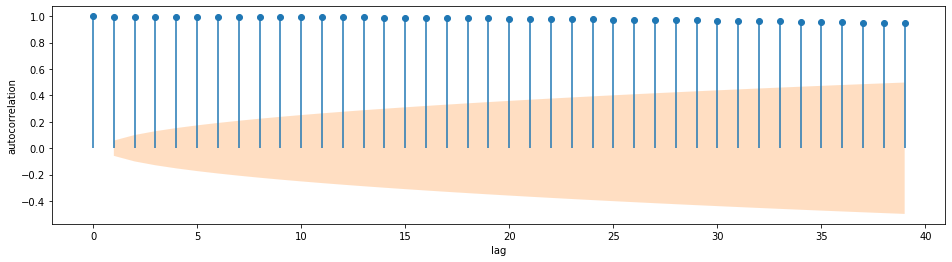

In [18]:
plot_acf(x)

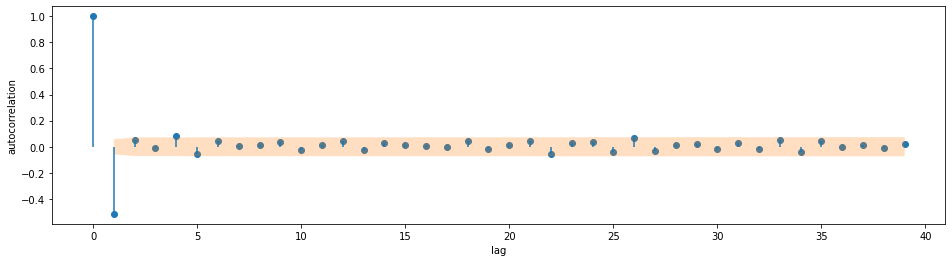

In [19]:
plot_acf(np.diff(x))

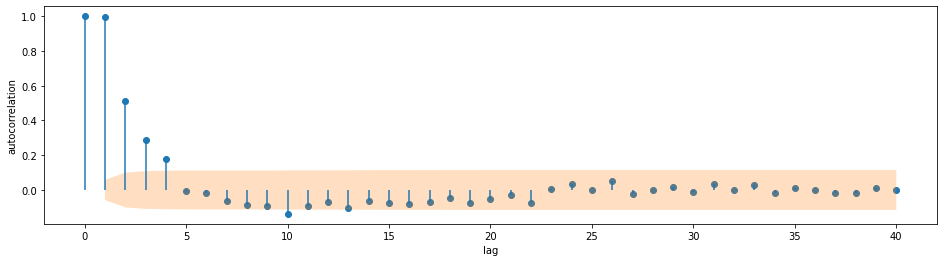

In [20]:
plot_pacf(x)

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
train_size = 600
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [23]:
# q, d, p
mod = ARIMA(1, 0, 4)
mod.fit(x_train)
pred = mod.predict(x_test)

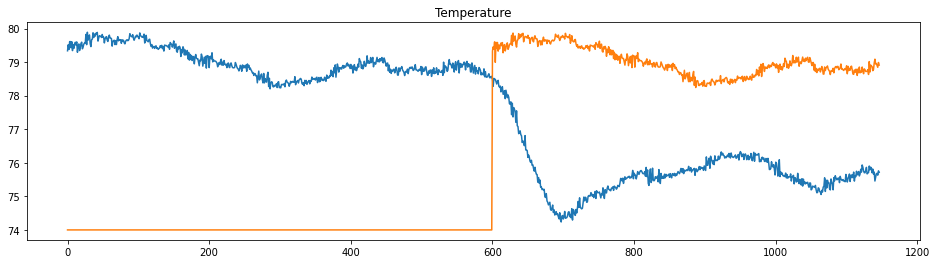

In [24]:
plt.figure(figsize=(16,4))
plt.title('Temperature')
plt.plot(x)
plt.plot(np.hstack([np.array([74] * train_size), pred]))

Остатки не распределены как белый шум, значит на отрезке, начиная с 600 есть аномалии

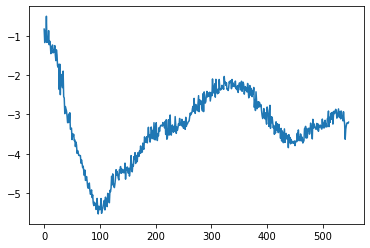

In [25]:
plt.plot(x_test - pred)

Теперь тоже самое для anomaly free датасета

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv("data/anomaly-free/anomaly-free.csv", sep=";", parse_dates=True, index_col="datetime")
df.head()

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
datetime,,,,,,,,
2020-02-08 13:30:47,0.202394,0.275154,2.16975,0.382638,90.6454,26.8508,238.852,122.664
2020-02-08 13:30:48,0.203153,0.277857,2.07999,-0.273216,90.7978,26.8639,227.943,122.338
2020-02-08 13:30:50,0.202054,0.275790,2.52577,0.382638,90.7730,26.8603,223.486,121.338
2020-02-08 13:30:51,0.203595,0.278101,2.49742,0.054711,90.8424,26.8616,244.904,121.664
2020-02-08 13:30:52,0.201889,0.276363,2.29194,0.710565,90.6664,26.8603,239.196,122.000


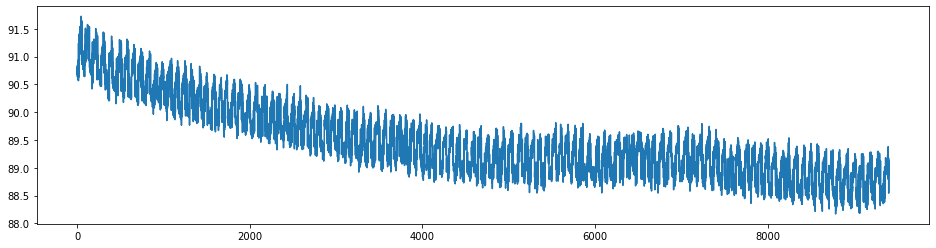

In [27]:
x = df["Temperature"].values

fig, ax = plt.subplots(figsize=(16,4))
ax.plot(x)

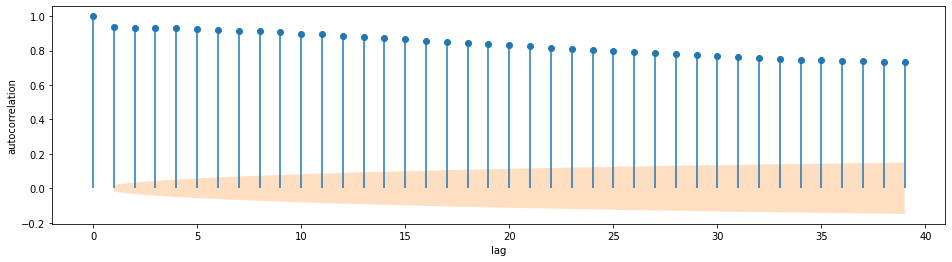

In [28]:
plot_acf(x)

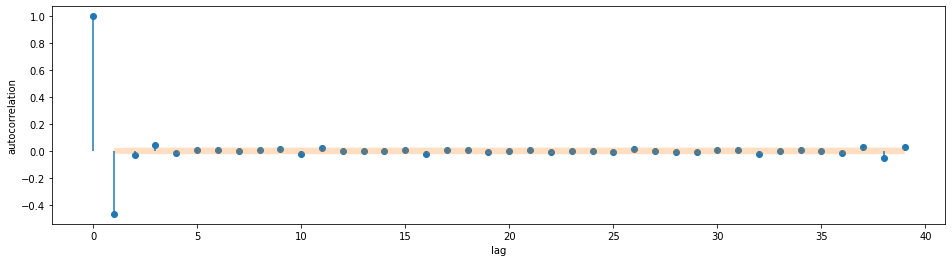

In [29]:
plot_acf(np.diff(x))

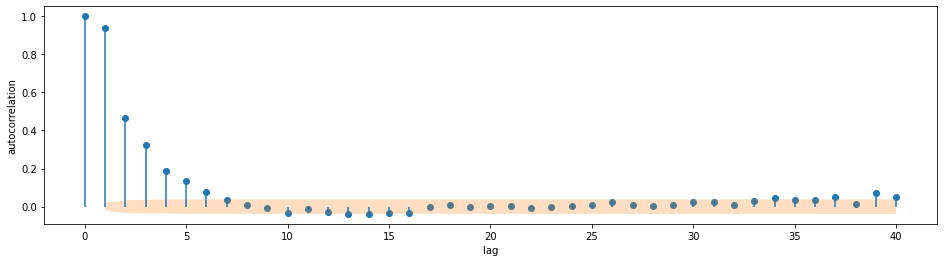

In [30]:
plot_pacf(x)

In [31]:
train_size = 5000
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [32]:
x.shape

(9405,)

In [33]:
# q, d, p
mod = ARIMA(1, 0, 5)
mod.fit(x_train)
pred = mod.predict(x_test)

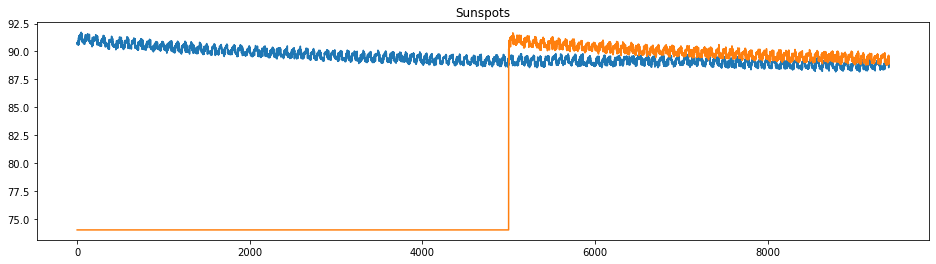

In [34]:
plt.figure(figsize=(16,4))
plt.title('Sunspots')
plt.plot(x)
plt.plot(np.hstack([np.array([74] * train_size), pred]))

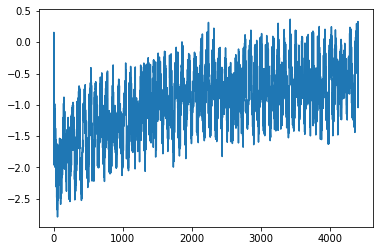

In [35]:
plt.plot(x_test - pred)

## VARMAX

In [46]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv("data/valve1/0.csv", sep=";", parse_dates=True, index_col="datetime")
x = df.T.values

In [53]:
from statsmodels.tsa.statespace.varmax import VARMAX

model = VARMAX(x)

In [56]:
model.fit()

LinAlgError: Matrix is not positive definite